# try adding captions and biography and vectorize it based on that.


In [1]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [2]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [3]:
from sklearn.preprocessing import LabelEncoder
train_classification_df = pd.read_csv("train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)

label_encoder = LabelEncoder()

# Fit and transform the 'category' column
train_classification_df["encoded_category"] = label_encoder.fit_transform(train_classification_df["category"])

# Create mapping of usernames to unified (lowercase) categories
#username2_category = train_classification_df.set_index("user_id")["category"].to_dict()

username2_category = train_classification_df.set_index("user_id").to_dict()["encoded_category"]

In [4]:
train_data_path = "training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [5]:
missing_profiles = [
    username for username in username2posts_train.keys()
    if username not in username2profile_train
]
print("Missing profiles:", missing_profiles)


Missing profiles: []


In [6]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re



def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s@#]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=7500)


# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re


def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s@#]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregating the posts, biography, and full name per user
    cleaned_text = []
    bio_user = username2profile_train[username].get("biography", "") or ""

    # Preprocess biography and prepend identifier
    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    # Preprocess captions and prepend identifier
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    corpus.append(user_text)

# Initialize TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(stop_words=turkish_stopwords, max_features=7000)

# Fit the vectorizer
vectorizer2.fit(corpus)

# Transform the data into vectors
x_train_vec = vectorizer2.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

# Process the test data similarly
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)

    cleaned_text = []
    bio_user = username2profile_test[username].get("biography", "") or ""

    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    test_corpus.append(user_text)

# Transform the test data (no fitting)
x_post_test = vectorizer2.transform(test_corpus)
#y_test = [username2_category.get(uname, "NA") for uname in test_usernames]


In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text: str):
    # Lowercase the text (casefold handles Turkish-specific letters)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation, but keep hashtags (#) and emojis
    # Unicode emoji range is retained along with hashtags
    text = re.sub(r'[^a-zçğıöşü0-9\s#\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregating the posts, biography, and full name per user
    cleaned_text = []
    bio_user = username2profile_train[username].get("biography", "") or ""

    # Preprocess biography and prepend identifier
    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    # Preprocess captions and prepend identifier
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    corpus.append(user_text)

# Initialize TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(stop_words=turkish_stopwords, max_features=8000)

# Fit the vectorizer
vectorizer2.fit(corpus)

# Transform the data into vectors
x_train_vec = vectorizer2.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

# Process the test data similarly
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)

    cleaned_text = []
    bio_user = username2profile_test[username].get("biography", "") or ""

    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    test_corpus.append(user_text)

# Transform the test data (no fitting)
x_test = vectorizer2.transform(test_corpus)
#y_test = [username2_category.get(uname, "NA") for uname in test_usernames]


In [8]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [9]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['ab', 'abd', 'abdulkadir', ..., 'şıklık', 'şıklığı', 'şımartın'],
      shape=(7500,), dtype=object)

In [126]:
df_tfidf = pd.DataFrame(x_train_vec.toarray(), columns=feature_names)
df_tfidf.head(2)

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şubesi,şunu,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047534,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [10]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045899,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def get_avg_like_count(username):
    def calculate_avg(posts: list):
        total = 0
        count = 0
        for post in posts:
            like_count = post.get("like_count", 0)
            if like_count is None:
                like_count = 0
            total += like_count
            count += 1

        return total / count if count > 0 else 0

    # Check if the username exists in training or testing data
    if username in username2posts_train:
        return calculate_avg(username2posts_train[username])
    elif username in username2posts_test:
        return calculate_avg(username2posts_test[username])
    else:
        print(f"No data available for {username}")
        return -1

# Initialize an empty list to store rows
data = []
# Loop through usernames in the training set
for username in train_usernames:
    # Get profile info for the user
    profile = username2profile_train[username]

    average_like = get_avg_like_count(username)
    # Extract profile-related features
    profile_info = {
        #"username": username,
        "follower_count": profile.get("follower_count", 0) or 0,
        "following_count": profile.get("following_count", 0) or 0,
        #"highlight_reel_count": profile.get("highlight_reel_count", 0) or 0,
        #"post_count": profile.get("post_count", 0) or 0,
        "is_verified": profile.get("is_verified", False),
        "is_business_account": profile.get("is_business_account", False),
        "is_private": profile.get("is_private", False),
        #"category_name": profile.get("category_name", "Unknown"),
        "average_like": average_like
    }
    #bio = profile.get("biography", "") or ""
    #if bio:
    #    bio = preprocess_text(bio)
    #    if bio:  # Ensure the processed caption is not empty
    #        bio_corpus.append(bio)

    data.append(profile_info)

# Convert the list of dictionaries into a DataFrame
df_train_pro = pd.DataFrame(data)

# label encoder
#label_encoder = LabelEncoder()
#df_train_pro["category_name"] = label_encoder.fit_transform(df_train_pro['category_name'])

# Fit and transform the TF-IDF vectorizer
#vectorizer_bio = TfidfVectorizer(stop_words=turkish_stopwords, max_features=500)
#x_bio_tfidf = vectorizer_bio.fit_transform(bio_corpus)
#tfidf_df_bio = pd.DataFrame(x_bio_tfidf.toarray(), columns=vectorizer_bio.get_feature_names_out())
#print(f"TF-IDF matrix shape: {x_bio_tfidf.shape}")

# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_train_pro[col] = df_train_pro[col].astype(int)

df_combined = pd.concat([df_train_pro.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)
df_combined.head()

,follower_count,following_count,is_verified,is_business_account,is_private,average_like,ab,abd,abdulkadir,abdullah,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,1167,192,0,1,0,11.542857,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.045899,0.0,0.0,0.0
1,11997,17,0,1,0,31.514286,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2321,454,0,1,0,233.885714,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.038769,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,13647,29,1,1,0,361.342857,0.0,0.0,0.0,0.04432,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,7917,11,1,1,0,72.800000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [44]:
# Compute the correlation matrix
correlation_matrix = df_train_pro.corr()

# Print the correlation matrix
correlation_matrix

,follower_count,following_count,is_verified,is_business_account,is_private,average_like
follower_count,1.000000,-0.003915,0.082114,-0.054047,-0.000672,0.107474
following_count,-0.003915,1.000000,0.091103,-0.156497,-0.006674,0.029898
is_verified,0.082114,0.091103,1.000000,-0.279183,0.034614,0.269230
is_business_account,-0.054047,-0.156497,-0.279183,1.000000,-0.030593,-0.189937
is_private,-0.000672,-0.006674,0.034614,-0.030593,1.000000,-0.003056
average_like,0.107474,0.029898,0.269230,-0.189937,-0.003056,1.000000


In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_train_pro)

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components (adjust as needed)
principal_components = pca.fit_transform(scaled_data)

# Step 3: Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [76]:
df_pca_tfidf = pd.concat([pca_df.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)
df_pca_tfidf.head()

,PC1,PC2,abdullah,abone,about,acele,acil,activities,acı,ad,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,-0.833127,-0.250891,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.050596,0.0,0.0
1,-0.880793,-0.377352,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,-0.757440,-0.065504,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.041839,0.0,0.0,0.000000,0.0,0.0
3,0.487451,-0.450489,0.047264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046548,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.478052,-0.460303,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


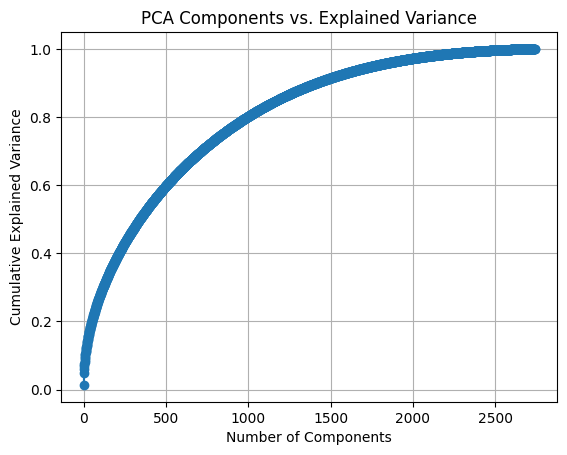

In [63]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Example: Fit Truncated SVD for 500 components
svd = TruncatedSVD(n_components=5000, random_state=42)
svd.fit(df_tfidf)  # tfidf_matrix is your sparse TF-IDF matrix

# Plot cumulative explained variance
cumulative_variance = svd.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Components vs. Explained Variance')
plt.grid(True)
plt.show()


In [77]:
# Step 2: Apply Truncated SVD
svd = TruncatedSVD(n_components=1000, random_state=42)  # Reduce to 1000 components
reduced_matrix = svd.fit_transform(df_tfidf)
# Convert to DataFrame
columns = [f'PC_TFIDF{i+1}' for i in range(reduced_matrix.shape[1])]  # Create column names like PC1, PC2, ...
reduced_df = pd.DataFrame(reduced_matrix, columns=columns)

In [78]:
df_pca_tfidf2 = pd.concat([pca_df.reset_index(drop=True), reduced_df.reset_index(drop=True)], axis=1)
df_pca_tfidf2.head()

,PC1,PC2,PC_TFIDF1,PC_TFIDF2,PC_TFIDF3,PC_TFIDF4,PC_TFIDF5,PC_TFIDF6,PC_TFIDF7,PC_TFIDF8,...,PC_TFIDF991,PC_TFIDF992,PC_TFIDF993,PC_TFIDF994,PC_TFIDF995,PC_TFIDF996,PC_TFIDF997,PC_TFIDF998,PC_TFIDF999,PC_TFIDF1000
0,-0.833127,-0.250891,0.269024,-0.139558,-0.080954,-0.066808,-0.101811,-0.035085,0.102197,-0.006323,...,0.013041,0.014036,-0.021737,0.042955,-0.024629,0.017940,0.005930,-0.016351,0.010717,-0.010679
1,-0.880793,-0.377352,0.226589,-0.147282,0.146178,-0.130297,0.135785,0.089875,-0.037135,-0.011430,...,-0.025563,-0.017170,-0.012957,-0.002709,0.010691,0.031411,-0.015486,-0.007714,0.008737,0.003591
2,-0.757440,-0.065504,0.266619,-0.162034,0.049504,0.068446,-0.044873,-0.018378,-0.004179,-0.024798,...,0.008726,0.012528,-0.010227,-0.012282,-0.007952,0.025163,0.011014,-0.035557,-0.013490,0.019328
3,0.487451,-0.450489,0.185837,-0.138679,-0.423346,0.127438,0.230933,0.035509,-0.117301,0.071120,...,-0.008603,0.014108,-0.013476,0.007031,-0.005655,-0.002491,-0.021406,-0.006128,0.023464,0.020097
4,0.478052,-0.460303,0.170445,-0.108853,-0.019233,-0.040576,-0.061433,-0.025996,-0.049397,0.009304,...,-0.003443,0.014602,-0.001048,-0.005319,-0.001527,0.010662,-0.023866,0.002679,-0.019114,0.002072


In [101]:
df_combined.head(2)

,follower_count,following_count,is_verified,is_business_account,is_private,average_like,ab,abd,abdulkadir,abdullah,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,1167,192,0,1,0,11.542857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045899,0.0,0.0,0.0
1,11997,17,0,1,0,31.514286,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [13]:
from sklearn.model_selection import train_test_split
X = df_tfidf
y = y_train
x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [14]:
x_train.head()

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
2638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051177,0.0,0.0
1736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [15]:
x_val.shape

(549, 7500)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

randforest = RandomForestClassifier(n_estimators=100, random_state=42)
param_grid = {   
    'max_depth': [None, 10, 20, 30, 50],         # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required at each leaf node
    'bootstrap': [True, False],                  # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy', 'log_loss'] # Splitting criteria
}



# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=randforest,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='accuracy',         # Metric for evaluation
    verbose=2,
    n_jobs=-1                   # Use all available cores
)

# Fit the model
grid_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best score
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the AdaBoost model
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Shrinks contribution of each learner
    'estimator__max_depth': [1, 3, 5],  # Depth of decision trees
}

# Grid Search
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("Best Parameters for AdaBoost:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for AdaBoost:", grid_search.best_score_)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [200],          # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],      # Shrinks contribution of each tree
    'max_depth': [3, 5, 7],                 # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples at a leaf node
    'subsample': [0.8, 1.0],                # Fraction of samples used per tree
    'max_features': ['sqrt', 'log2']  # Number of features to consider for splits
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring='accuracy',                     # Metric for optimization
    cv=5,                                   # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                               # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the SVC model
svc = SVC(random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 50, 100],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
    'degree': [2, 3, 4],                  # Degree for 'poly' kernel
    'class_weight': [None, 'balanced']   # Weighting for imbalanced datasets
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',                  # Metric to optimize
    cv=5,                                # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                            # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Best parameters and score
print("Best Parameters for SVC:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for SVC:", grid_search.best_score_)




In [ ]:
# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_val)
print("Test Accuracy:", accuracy_score(y_val, y_pred))

In [182]:
#BEST RESULT UNTILL NOW

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)),
        ('svm', SVC(kernel='rbf', class_weight='balanced', C=50, gamma=0.005) )
    ],
    final_estimator=LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
)

# Train stacking model
stacking_model.fit(x_train, y_train)

# Evaluate
y_val_pred_stacking = stacking_model.predict(x_val)
print("Stacking Classifier - Accuracy:", accuracy_score(y_val, y_val_pred_stacking))
print("\nStacking Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifier - Accuracy: 0.6885245901639344

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.32      0.37        38
           1       0.52      0.43      0.47        65
           2       0.64      0.82      0.72        60
           3       0.85      0.92      0.89       102
           4       0.00      0.00      0.00         3
           5       0.68      0.69      0.68       100
           6       0.75      0.60      0.67        30
           7       0.52      0.65      0.58        23
           8       0.70      0.71      0.71        69
           9       0.79      0.75      0.77        59

    accuracy                           0.69       549
   macro avg       0.59      0.59      0.58       549
weighted avg       0.68      0.69      0.68       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the MLPClassifier
mlp = MLPClassifier(max_iter=500, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100)],  # Layer configurations
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],       # Solvers for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term (L2 penalty)
    'learning_rate': ['adaptive'],  # Learning rate schedule
    'learning_rate_init': [0.001, 0.01, 0.1]    # Initial learning rate
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters for MLPClassifier:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for MLPClassifier:", grid_search.best_score_)


In [ ]:
# Evaluate on test data
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(x_val)
print("Test Accuracy for Optimized MLPClassifier:", accuracy_score(y_val, y_pred))

In [190]:
# NEW BEST RESULT

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)),
        ('lr_l1', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf') ),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam')) # Neural Network
    ],
    final_estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
)

# Train stacking model
stacking_model.fit(x_train, y_train)

# Evaluate
y_val_pred_stacking = stacking_model.predict(x_val)
print("Stacking Classifier - Accuracy:", accuracy_score(y_val, y_val_pred_stacking))
print("\nStacking Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifier - Accuracy: 0.6939890710382514

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.39      0.42        38
           1       0.54      0.43      0.48        65
           2       0.60      0.82      0.70        60
           3       0.84      0.90      0.87       102
           4       0.00      0.00      0.00         3
           5       0.69      0.70      0.70       100
           6       0.85      0.57      0.68        30
           7       0.70      0.70      0.70        23
           8       0.66      0.71      0.69        69
           9       0.83      0.76      0.80        59

    accuracy                           0.69       549
   macro avg       0.62      0.60      0.60       549
weighted avg       0.69      0.69      0.69       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

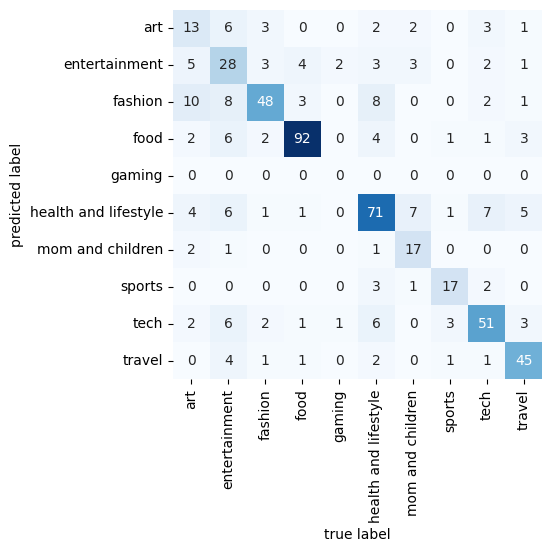

In [187]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
mat = confusion_matrix(y_val, y_val_pred_stacking)


# Create a heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

# Add axis labels
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


In [192]:
#trial with MLPclassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
voting_model = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf') ),
        ('lr_l2', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam')) # Neural Network
    ],
    voting = 'soft'
)

# Train stacking model
stacking_model.fit(x_train, y_train)

# Evaluate
y_val_pred_stacking = stacking_model.predict(x_val)
print("Stacking Classifier - Accuracy:", accuracy_score(y_val, y_val_pred_stacking))
print("\nStacking Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifier - Accuracy: 0.6903460837887068

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.32      0.34        38
           1       0.56      0.45      0.50        65
           2       0.59      0.78      0.68        60
           3       0.85      0.89      0.87       102
           4       0.00      0.00      0.00         3
           5       0.67      0.70      0.68       100
           6       0.83      0.50      0.62        30
           7       0.73      0.70      0.71        23
           8       0.68      0.75      0.71        69
           9       0.82      0.80      0.81        59

    accuracy                           0.69       549
   macro avg       0.61      0.59      0.59       549
weighted avg       0.69      0.69      0.68       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [193]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],       # Number of neighbors to consider
    'weights': ['uniform', 'distance'],    # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metrics
    'p': [1, 2]                            # Power parameter for Minkowski metric (1=Manhattan, 2=Euclidean)
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',                    # Metric to optimize
    cv=5,                                  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                              # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters for KNN:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for KNN:", grid_search.best_score_)



Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.4s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.4s
[CV] END metric=euclidean, n_neighbors=3, p=2, weights=uniform; total time=   0.3s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.4s
[CV] END metric=eucl

In [16]:
#NEW NEW BESTTT
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC


# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)),
        ('lr_l2', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf') ),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam')) # Neural Network
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)
)

# Train stacking model
stacking_model.fit(x_train, y_train)

# Evaluate
y_val_pred_stacking = stacking_model.predict(x_val)
print("Stacking Classifier - Accuracy:", accuracy_score(y_val, y_val_pred_stacking))
print("\nStacking Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

Stacking Classifier - Accuracy: 0.6739526411657559

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.13      0.19        38
           1       0.44      0.40      0.42        65
           2       0.54      0.73      0.62        60
           3       0.87      0.92      0.90       102
           4       0.00      0.00      0.00         3
           5       0.68      0.76      0.72       100
           6       0.59      0.43      0.50        30
           7       0.73      0.70      0.71        23
           8       0.73      0.81      0.77        69
           9       0.74      0.68      0.71        59

    accuracy                           0.67       549
   macro avg       0.57      0.56      0.55       549
weighted avg       0.66      0.67      0.66       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [35]:
from sklearn.model_selection import cross_val_score
#NEW NEW BESTTT
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
stacking_model2 = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8, random_state=42)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)),
        ('lr_l2', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf', random_state=42) ),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam', random_state=42)) # Neural Network
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)
)

# Use cross-validation to get a stable performance estimate
scores = cross_val_score(stacking_model2, X, y, cv=5)
print(f"Mean Accuracy: {scores.mean():.2f}")

Mean Accuracy: 0.68


In [ ]:
from sklearn.model_selection import cross_val_score
#NEW NEW BESTTT
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
stacking_model2 = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8, random_state=42)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)),
        ('lr_l2', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf', random_state=42) ),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam', random_state=42)) # Neural Network
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)
)

# Use cross-validation to get a stable performance estimate
scores = cross_val_score(stacking_model2, X_scaled, y, cv=5)
print(f"Mean Accuracy: {scores.mean():.2f}")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)

# Train stacking model
stacking_model.fit(x_train, y_train)

# Evaluate
y_val_pred_stacking = stacking_model.predict(x_val)
print("Stacking Classifier - Accuracy:", accuracy_score(y_val, y_val_pred_stacking))
print("\nStacking Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

Stacking Classifier - Accuracy: 0.6648451730418944

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        38
           1       0.41      0.51      0.45        65
           2       0.61      0.75      0.67        60
           3       0.84      0.87      0.86       102
           4       0.00      0.00      0.00         3
           5       0.62      0.73      0.67       100
           6       0.82      0.47      0.60        30
           7       0.67      0.35      0.46        23
           8       0.72      0.72      0.72        69
           9       0.81      0.73      0.77        59

    accuracy                           0.66       549
   macro avg       0.60      0.54      0.55       549
weighted avg       0.67      0.66      0.66       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

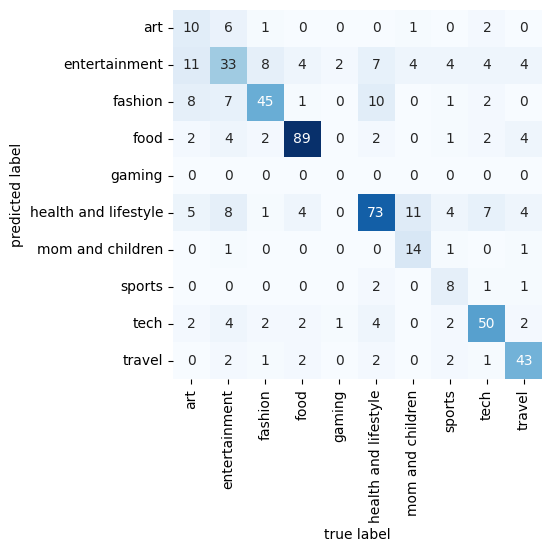

In [158]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
mat = confusion_matrix(y_val, y_val_pred_stacking)


# Create a heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

# Add axis labels
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


In [163]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(x_train, y_train)
print(grid.best_params_)

CPU times: user 16min 38s, sys: 4.29 s, total: 16min 43s
Wall time: 16min 45s
{'C': 50, 'gamma': 0.005}


In [164]:
model = grid.best_estimator_
yfit = model.predict(x_val)

# Train stacking model
#model.fit(x_train, y_train)

# Evaluate
#y_val_pred_model = model.predict(x_val)
print("SVM Classifier - Accuracy:", accuracy_score(y_val, yfit))
print("\nSVM Classifier - Classification Report:")
print(classification_report(y_val, y_val_pred_stacking))

SVM Classifier - Accuracy: 0.6593806921675774

SVM Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        38
           1       0.41      0.51      0.45        65
           2       0.61      0.75      0.67        60
           3       0.84      0.87      0.86       102
           4       0.00      0.00      0.00         3
           5       0.62      0.73      0.67       100
           6       0.82      0.47      0.60        30
           7       0.67      0.35      0.46        23
           8       0.72      0.72      0.72        69
           9       0.81      0.73      0.77        59

    accuracy                           0.66       549
   macro avg       0.60      0.54      0.55       549
weighted avg       0.67      0.66      0.66       549



/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monsieurerkan/Downloads/CS412_REGRESSION_PROJECT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

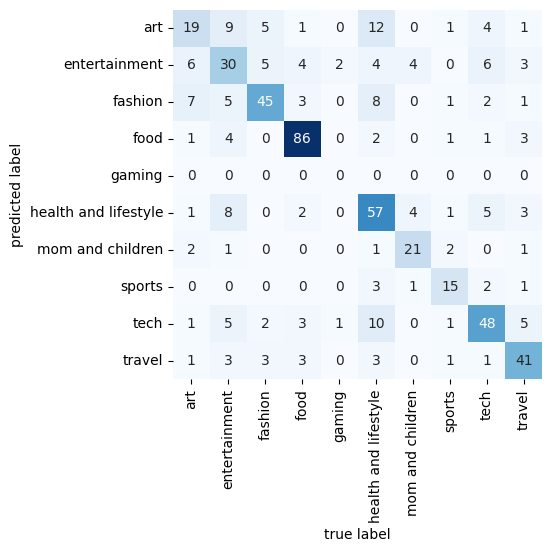

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
mat = confusion_matrix(y_val, yfit)


# Create a heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

# Add axis labels
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


In [19]:
#@title Test Data


# let's take a look at the first 5 lines of the file
test_data_path = "test-classification-round3.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

livapastanesi
barisgross
tusasshop
etolyadigital
tugrulonur
*****
['livapastanesi', 'barisgross', 'tusasshop', 'etolyadigital', 'tugrulonur']


In [20]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)




In [21]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.shape

(1000, 7500)

In [22]:
test_pred = stacking_model.predict(df_test)
original_categories = label_encoder.inverse_transform(test_pred)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = original_categories[index]

In [23]:
print("Length of test_unames:", len(test_unames))
print("Length of test_pred:", len(test_pred))
print("Length of original_categories:", len(original_categories))


Length of test_unames: 1000
Length of test_pred: 1000
Length of original_categories: 1000


In [24]:
with open("prediction-classification-round3.json", "w") as of:
  json.dump(output, of, indent=4)